# Fesabilité classification des images


## Import des librairies


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ast
import time
from matplotlib.image import imread
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from sklearn.metrics.cluster import adjusted_rand_score

## Import des données


In [53]:
df_product_clean = pd.read_csv("dataset/Flipkart/flipkart_clean.csv")


# Create a function for split the first category
def extract_words_category(chaine):
    liste = ast.literal_eval(chaine)
    return liste[0].split(">>")[0]


# Apply function to a new column
df_product_clean["first_category"] = df_product_clean["product_category_tree"].apply(
    extract_words_category
)
df_product_clean["first_category"] = df_product_clean["first_category"].str.rstrip()
df_product_clean.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,first_category
0,55b85ea15a1536d46b7190ad6fff8ce7,30-04-2016 03:22:56,http://www.flipkart.com/elegance-polyester-mul...,elegance polyester multicolor abstract eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,key feature elegance polyester multicolor abst...,No rating available,No rating available,Elegance,"{'product_specification': [{'key': 'Brand', 'v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,30-04-2016 03:22:56,http://www.flipkart.com/sathiyas-cotton-bath-t...,sathiyas cotton bath towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,specification sathiyas cotton bath towel bath ...,No rating available,No rating available,Sathiyas,{'product_specification': [{'key': 'Machine Wa...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,30-04-2016 03:22:56,http://www.flipkart.com/eurospa-cotton-terry-f...,eurospa cotton terry face towel set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,999.0,600.0,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,key feature eurospa cotton terry face towel se...,No rating available,No rating available,Eurospa,"{'product_specification': [{'key': 'Material',...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,20-06-2016 08:49:52,http://www.flipkart.com/santosh-royal-fashion-...,santosh royal fashion cotton printed king size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,key feature santosh royal fashion cotton print...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{'product_specification': [{'key': 'Brand', 'v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,20-06-2016 08:49:52,http://www.flipkart.com/jaipur-print-cotton-fl...,jaipur print cotton floral king sized double b...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,key feature jaipur print cotton floral king si...,No rating available,No rating available,Jaipur Print,{'product_specification': [{'key': 'Machine Wa...,Home Furnishing


## classification automatique d’images via SIFT


### Ajout des labels pour chaque images


In [54]:
# add path folder image to images column
path_folder_image = "dataset/Flipkart/Images/"
df_product_clean["image"] = path_folder_image + df_product_clean["image"].astype(str)
# Create label encoder for each categories in dataframe
le = preprocessing.LabelEncoder()
le.fit(df_product_clean["first_category"])
df_product_clean["label"] = le.transform(df_product_clean["first_category"])
df_product_clean["label"] = le.transform(df_product_clean["first_category"])

### Verification des categories par images


In [55]:
df_product_clean["first_category"].value_counts()

first_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

Nos categories qui seront nos label pour la classification sont bien répartie


### Pré-visualisation des images en fonction de leurs labels


Home Furnishing


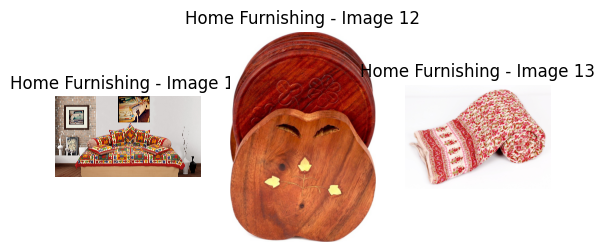

Baby Care


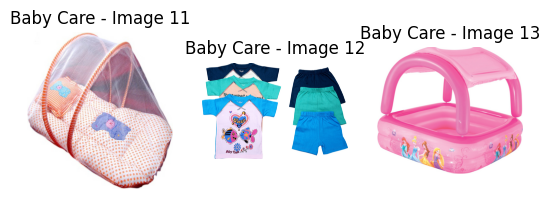

Watches


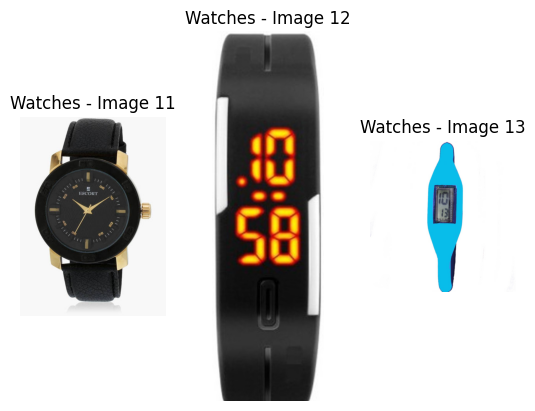

Home Decor & Festive Needs


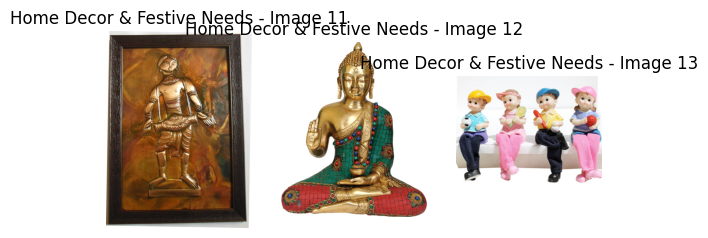

Kitchen & Dining


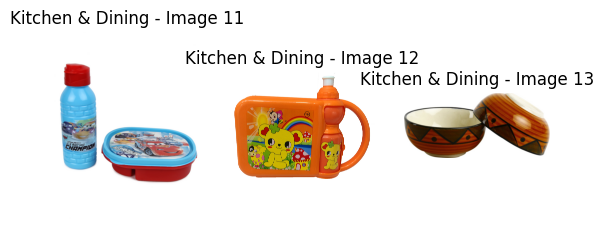

Beauty and Personal Care


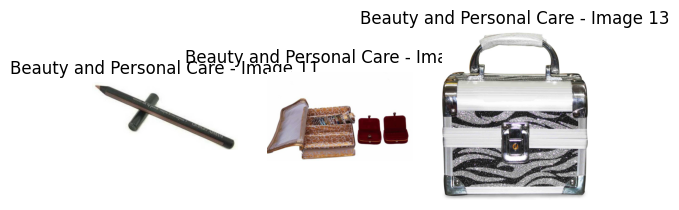

Computers


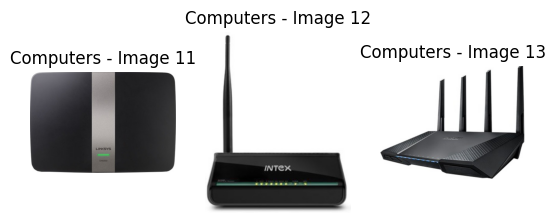

In [56]:
list_labels = df_product_clean["first_category"].unique()


# Create a function for match image with label
def list_fct(name):
    list_image_name = [
        df_product_clean["image"][i]
        for i in range(len(df_product_clean))
        if df_product_clean["first_category"][i] == name
    ]
    return list_image_name


list_home = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Home Furnishing"
]
list_baby = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Baby Care"
]
list_watches = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Watches"
]
list_home_decor = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Home Decor & Festive Needs"
]

list_kitchen = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Kitchen & Dining"
]
list_beauty = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Beauty and Personal Care"
]

list_beauty = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Computers"
]

for name in list_labels:
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        filename = list_fct(name)[i + 10]
        image = imread(filename)
        plt.axis("off")
        plt.imshow(image)
        plt.title(f"{name} - Image {i + 11}")
    plt.show()

### Classification des images (algorithme SIFT)


#### Pré-traitement sur une image : Détermination et affichage des descripteurs SIFT


dataset/Flipkart/Images/e9420e9483f16db81c64dddf99f34841.jpg
Descripteurs :  (4061, 128)

[[106.  45.   0. ...   0.   0.   8.]
 [103.  44.   0. ...   0.   1.   3.]
 [104.  28.   1. ...   0.   0.   4.]
 ...
 [ 34.   7.   1. ...   0.   0.   2.]
 [ 49.   5.   0. ...   0.   0.   0.]
 [ 17.   3.   1. ...   0.   0.   1.]]


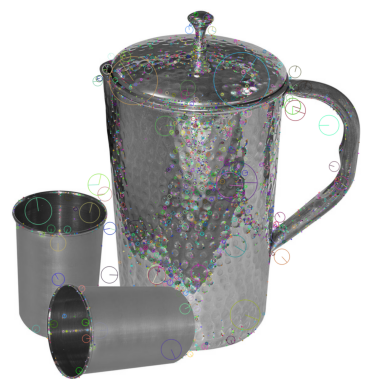

In [57]:
# display descriptor SIFT
test_image_path = df_product_clean.image.sample().values[0]
sift = cv2.SIFT_create()
print(test_image_path)
image_test = cv2.imread(test_image_path)
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)

kp, descript = sift.detectAndCompute(image_test, None)
img = img = cv2.drawKeypoints(
    image_test, kp, image_test, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.axis("off")
plt.imshow(img)
print("Descripteurs : ", descript.shape)
print()
print(descript)

#### Prétraitement de chaque images


On va va convertir chaque image en gris création d'une function a appliquer sur nos images


In [58]:
def preprocessing_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur de chargement de l'image : {image_path}")
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    return gray

In [59]:
df_product_clean["image_preprocessing"] = df_product_clean["image"].apply(
    lambda x: preprocessing_image(x)
)

#### Création des descripteurs et cluster pour chaque image


In [60]:
# Initialiser SIFT avec un nombre maximum de points clés
n_features = 500  # Réduire pour limiter les descripteurs
sift = cv2.SIFT_create(nfeatures=n_features)

# Définir le nombre de clusters (visual words) et la taille du batch
num_clusters = 300  # Exemple : 100 visual words
batch_size = 10000  # Nombre total de descripteurs par batch

# Initialiser MiniBatchKMeans
kmeans = MiniBatchKMeans(
    n_clusters=num_clusters, random_state=42, batch_size=batch_size
)

# Enregistrer le temps de début
temps1 = time.time()

# Initialiser la liste pour stocker tous les descripteurs
sift_keypoints = []

# Utiliser tqdm pour suivre la progression
for i, image_file in enumerate(
    tqdm(df_product_clean["image"], desc="Traitement des images")
):
    if i % 100 == 0:
        print(f"Traitement de l'image {i+1}/{len(df_product_clean)}")

    # Lire l'image
    image = cv2.imread(image_file)
    if image is None:
        print(f"Erreur de chargement de l'image : {image_file}")
        continue  # Passer à l'image suivante

    # Convertir en niveaux de gris
    try:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        print(
            f"Erreur de conversion en niveaux de gris pour l'image {image_file} : {e}"
        )
        continue  # Passer à l'image suivante

    # Optionnel : égaliser l'histogramme pour améliorer le contraste
    gray_image = cv2.equalizeHist(gray_image)

    # Optionnel : Redimensionner l'image pour réduire la taille
    desired_size = (300, 300)  # Ajustez selon vos besoins
    gray_image = cv2.resize(gray_image, desired_size)

    # Détecter les points clés et calculer les descripteurs
    kp, des = sift.detectAndCompute(gray_image, None)

    # Vérifier si des descripteurs ont été trouvés
    if des is not None:
        sift_keypoints.append(des)

    # Calculer le nombre total de descripteurs dans le batch
    current_batch_size = sum(len(d) for d in sift_keypoints)

    # Lorsque la taille du batch est atteinte, entraîner MiniBatchKMeans
    if current_batch_size >= batch_size:
        # Empiler les descripteurs en un seul tableau
        try:
            all_descriptors = np.vstack(sift_keypoints)
        except ValueError as ve:
            print(f"Erreur lors de l'empilement des descripteurs : {ve}")
            continue

        # Entraîner MiniBatchKMeans avec les descripteurs du batch
        kmeans.partial_fit(all_descriptors)

# Traiter les descripteurs restants après la boucle
if sift_keypoints:
    try:
        all_descriptors = np.vstack(sift_keypoints)
        kmeans.partial_fit(all_descriptors)
    except ValueError as ve:
        print(f"Erreur lors de l'empilement des descripteurs restants : {ve}")

# Obtenir les centres de clusters (visual words)
visual_words = kmeans.cluster_centers_

# Calculer la durée
duration1 = time.time() - temps1
print("Temps de traitement SIFT descriptor : ", f"{duration1:.2f}", "secondes")
print("Nombre de clusters (visual words) : ", visual_words.shape[0])

Traitement des images:   0%|          | 3/1050 [00:00<00:36, 28.83it/s]

Traitement de l'image 1/1050


Traitement des images:  10%|▉         | 103/1050 [00:04<00:42, 22.11it/s]

Traitement de l'image 101/1050


Traitement des images:  19%|█▉        | 202/1050 [00:10<00:55, 15.18it/s]

Traitement de l'image 201/1050


Traitement des images:  29%|██▉       | 302/1050 [00:18<01:08, 10.85it/s]

Traitement de l'image 301/1050


Traitement des images:  38%|███▊      | 401/1050 [00:29<01:09,  9.30it/s]

Traitement de l'image 401/1050


Traitement des images:  48%|████▊     | 501/1050 [00:42<01:25,  6.44it/s]

Traitement de l'image 501/1050


Traitement des images:  57%|█████▋    | 601/1050 [00:57<01:14,  6.03it/s]

Traitement de l'image 601/1050


Traitement des images:  67%|██████▋   | 701/1050 [01:16<01:17,  4.51it/s]

Traitement de l'image 701/1050


Traitement des images:  76%|███████▋  | 801/1050 [01:38<00:48,  5.13it/s]

Traitement de l'image 801/1050


Traitement des images:  86%|████████▌ | 900/1050 [02:00<00:42,  3.51it/s]

Traitement de l'image 901/1050


Traitement des images:  95%|█████████▌| 1000/1050 [02:28<00:17,  2.94it/s]

Traitement de l'image 1001/1050


Traitement des images: 100%|██████████| 1050/1050 [02:45<00:00,  6.34it/s]


Temps de traitement SIFT descriptor :  165.94 secondes
Nombre de clusters (visual words) :  300


In [61]:
print("Nombre de descripteurs : ", all_descriptors.shape)

Nombre de descripteurs :  (410039, 128)


#### Création des features d'images


In [62]:
# Creation of histograms (features)
temps1 = time.time()


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(visual_words))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Temps de création des histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
Temps de création des histogrammes :             0.58 secondes


In [63]:
im_features.shape

(1050, 300)

#### Réduction des dimmension ACP


In [68]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
acp = PCA(n_components=0.99)
X_img_acp = acp.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", X_img_acp.shape)

Dimensions dataset avant réduction PCA :  (1050, 300)
Dimensions dataset après réduction PCA :  (1050, 255)


#### Analyse visuel via T-SNE

##### affichage T-SNE selon catégories d'images

/home/dimitri/anaconda3/envs/projet6_env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


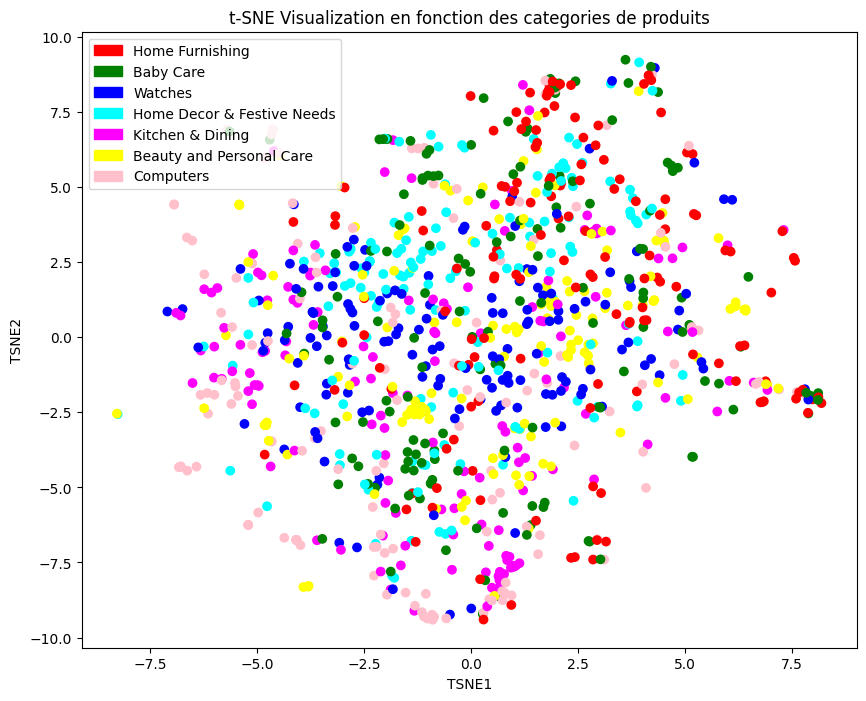

In [69]:
# Apply TSNE to data
colors = {
    "Home Furnishing": "red",
    "Baby Care": "green",
    "Watches": "blue",
    "Home Decor & Festive Needs": "cyan",
    "Kitchen & Dining": "magenta",
    "Beauty and Personal Care": "yellow",
    "Computers": "pink",
}
color_list = [colors[group] for group in df_product_clean["first_category"]]
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_img_acp)

# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_category_img"] = tsne_results[:, 0]
df_product_clean["TSNE2_category_img"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_category_img"],
    df_product_clean["TSNE2_category_img"],
    c=color_list,
)
legend_handles = [
    mpatches.Patch(color=colors["Home Furnishing"], label="Home Furnishing"),
    mpatches.Patch(color=colors["Baby Care"], label="Baby Care"),
    mpatches.Patch(color=colors["Watches"], label="Watches"),
    mpatches.Patch(
        color=colors["Home Decor & Festive Needs"], label="Home Decor & Festive Needs"
    ),
    mpatches.Patch(color=colors["Kitchen & Dining"], label="Kitchen & Dining"),
    mpatches.Patch(
        color=colors["Beauty and Personal Care"], label="Beauty and Personal Care"
    ),
    mpatches.Patch(color=colors["Computers"], label="Computers"),
]
plt.legend(handles=legend_handles, loc="upper left")
plt.title("t-SNE Visualization en fonction des categories de produits")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

##### Affichage des images selon les clusters 

In [70]:
main_categ_list = df_product_clean["first_category"].unique().tolist()

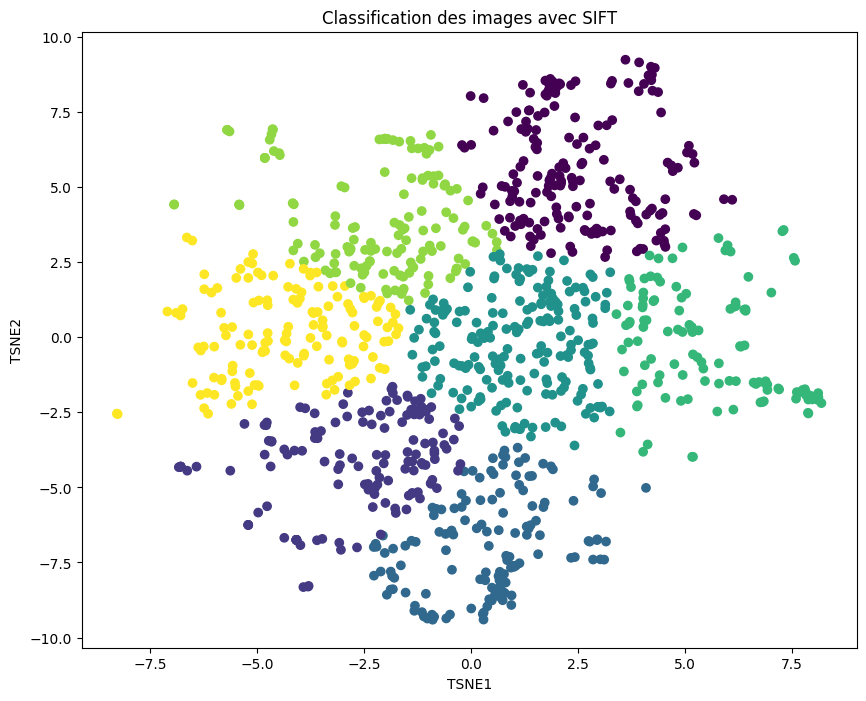

In [71]:
# Apply K-Means clustering

kmeans = KMeans(n_clusters=len(main_categ_list), random_state=42)
df_product_clean["cluster_img_sift"] = kmeans.fit_predict(tsne_results)


# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_sift"] = tsne_results[:, 0]
df_product_clean["TSNE2_sift"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_sift"],
    df_product_clean["TSNE2_sift"],
    c=df_product_clean["cluster_img_sift"],
)
plt.title("Classification des images avec SIFT")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Comparaison catégorie réelle/clustering K-means (ARI score)


In [72]:
clusters_labels = kmeans.labels_

In [75]:
ari = adjusted_rand_score(df_product_clean["first_category"], clusters_labels)
print(f"Adjusted Rand Index (ARI) avec SIFT : {ari}")

Adjusted Rand Index (ARI) avec SIFT : 0.04989467238441309
